2021.05.18
Author: Vin

This project is purely a practice for NLP techniques. In the project, I have mainly used three different methods, LDA, Word2Vec and TF-IWF(which was a derivative of TF-IDF) to extract the keywords. The dataset was from Kaggle user Larxel (https://www.kaggle.com/andrewmvd/business-analyst-jobs). It contains 4092 job adverts for Business Analysts position. The purpose of this project is to extract keywords from the description of these job listings with NLP techniques and, if possible, conclude core points for the position of Business Analyst.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import jieba.analyse
from snownlp import SnowNLP
from textrank4zh import TextRank4Keyword, TextRank4Sentence
from textblob import TextBlob
import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from stemming.porter2 import stem
import math
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# 1.Data Loading and Preprocession

### 1.1 Data Loading

In [3]:
data0 = pd.read_csv(r"./data/BusinessAnalyst.csv")
data = data0.copy()

In [4]:
print("There are {} rows of data in total in the dataset".format(len(data)))
print('Features in the dataset are {}'.format(list(data.columns)))

There are 4092 rows of data in total in the dataset
Features in the dataset are ['Unnamed: 0', 'index', 'Job Title', 'Salary Estimate', 'Job Description', 'Rating', 'Company Name', 'Location', 'Headquarters', 'Size', 'Founded', 'Type of ownership', 'Industry', 'Sector', 'Revenue', 'Competitors', 'Easy Apply']


### 1.2 Fix the data dislocation problem

The original dataset has data dislocation problem as rows with id larger than 3692 had moved backward by two columns. 

In [5]:
# There are 400 rows of data has dislocated
temp1 = data0.iloc[0:3692,2:]
temp2 = data0.iloc[3692:,0:-2]

temp1.columns = data0.columns[2:]
temp2.columns = data0.columns[2:]

data = pd.concat([temp1,temp2])
data.head(10)

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,Easy Apply
0,Business Analyst - Clinical & Logistics Platform,$56K-$102K (Glassdoor est.),Company Overview\n\n\nAt Memorial Sloan Ketter...,3.9,Memorial Sloan-Kettering\n3.9,"New York, NY","New York, NY",10000+ employees,1884,Nonprofit Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),"Mayo Clinic, The Johns Hopkins Hospital, MD An...",-1
1,Business Analyst,$56K-$102K (Glassdoor est.),We are seeking for an energetic and collaborat...,3.8,Paine Schwartz Partners\n3.8,"New York, NY","New York, NY",1 to 50 employees,-1,Company - Private,Venture Capital & Private Equity,Finance,Unknown / Non-Applicable,-1,True
2,Data Analyst,$56K-$102K (Glassdoor est.),"For more than a decade, Asembia has been worki...",3.6,Asembia\n3.6,"Florham Park, NJ","Florham Park, NJ",501 to 1000 employees,2004,Company - Private,Biotech & Pharmaceuticals,Biotech & Pharmaceuticals,$5 to $10 million (USD),-1,-1
3,"Information Security Analyst, Incident Response",$56K-$102K (Glassdoor est.),Job Description Summary\nThe Information Secur...,3.6,BD\n3.6,"Franklin Lakes, NJ","Franklin Lakes, NJ",10000+ employees,1897,Company - Public,Health Care Products Manufacturing,Manufacturing,$10+ billion (USD),"Abbott, Siemens, Baxter",-1
4,Analyst - FP&A Global Revenue,$56K-$102K (Glassdoor est.),Magnite is the world's largest independent sel...,3.4,Rubicon Project\n3.4,"New York, NY","Los Angeles, CA",201 to 500 employees,2007,Company - Public,Internet,Information Technology,$100 to $500 million (USD),"PubMatic, AppNexus, Index Exchange",True
5,Data Analyst,$56K-$102K (Glassdoor est.),Sapphire Digital seeks a dynamic and driven mi...,3.4,Sapphire Digital\n3.4,"Lyndhurst, NJ","Lyndhurst, NJ",201 to 500 employees,2019,Company - Private,Internet,Information Technology,Unknown / Non-Applicable,"Zocdoc, Healthgrades",-1
6,Investment Analyst - Graduate,$56K-$102K (Glassdoor est.),About Swiss Re\n\nThe Swiss Re Group is one of...,3.8,Swiss Re\n3.8,"New York, NY","Zurich, Switzerland",10000+ employees,1863,Company - Public,Insurance Agencies & Brokerages,Insurance,$10+ billion (USD),"Munich Re, Hannover RE, SCOR",-1
7,IT Business Process Analysis,$56K-$102K (Glassdoor est.),Bristol-Myers Squibb is a global Biopharma com...,3.8,Bristol-Myers Squibb\n3.8,"Jersey City, NJ","New York, NY",10000+ employees,1858,Company - Public,Biotech & Pharmaceuticals,Biotech & Pharmaceuticals,$10+ billion (USD),-1,-1
8,Tolling Business Analyst,$56K-$102K (Glassdoor est.),"At Gannett Fleming, we believe in improving th...",4.2,Gannett Fleming\n4.2,"New York, NY","Camp Hill, PA",1001 to 5000 employees,1915,Company - Private,Architectural & Engineering Services,Business Services,$100 to $500 million (USD),STV,-1
9,Business Analyst - Risk,$56K-$102K (Glassdoor est.),You'll work in our Risk practice in New York. ...,4.4,McKinsey\n4.4,"New York, NY","New York, NY",10000+ employees,1926,Company - Private,Consulting,Business Services,Unknown / Non-Applicable,"Boston Consulting Group, Bain & Company, Strat...",-1


### 1.3 Check missing values for the dataset

As we mainly concerned about the job description, and there is no missing values in this feature, no operation has been done to fill in the blank cells. 

In [6]:
def countNA(x):
    return sum(x.isnull())

data.replace({'-1':None}, inplace=True)
data.apply(countNA, axis=0)

Job Title               0
Salary Estimate         0
Job Description         0
Rating                 38
Company Name            0
Location                0
Headquarters          220
Size                  210
Founded              1066
Type of ownership     210
Industry              524
Sector                524
Revenue               210
Competitors          2987
Easy Apply           3958
dtype: int64

# 2. EDA for Industry
The main focus for this word is 'NLP', thus, only few EDA analysis will be delivered.

The barchart below shows in which industries there are the most requirement for Business analysts. From the chart, it shows that the industry 'Bank & Credit Unions' has the most positions for BA. Moreover, 'Accounting', 'Advertising & Marketing', 'Aerospace & Defense', 'Biotech & Pharmaceuticals' and 'Colleges & Universities' also have a certain number of BA. The most positions for BA were in the top 6 industries while the rest industries only provided few opportunites. 

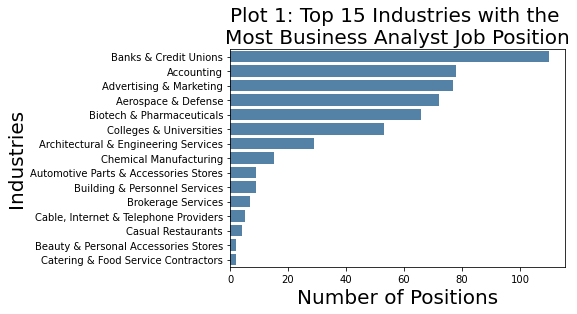

In [7]:
temp = data.groupby('Industry', as_index=False).agg(Job_Num=('Job Title','count'))

_ = sns.barplot(x='Job_Num', 
                y='Industry', 
                data=temp.head(15), 
                order=temp.head(15).sort_values('Job_Num', ascending=False).Industry, 
                color="steelblue")

_ = plt.title('Plot 1: Top 15 Industries with the \nMost Business Analyst Job Position', fontsize=20)
_ = plt.ylabel('Industries', fontsize=20)
_ = plt.xlabel('Number of Positions', fontsize=20)

_ = plt.show()

# EDA for Salary

Plot 2 and Plot 3 demonstrate the salary of BA position. Since in the original listing, the salary was recorded as a range, such as '$60k-$80k', I convert this type of data into average salary for the purpose of quntification. For example, '$60k-$80k' will become 70K and '$60k-$90k' will become 75K ect. From Plot 2, it can be seen that the minimum and maximum salary for BA are around $40k and $170K. Most of the positions offer salary around $50k to $100k, while there were few positions offering salary larger than $100k. PLot 3 shows the top 15 industries which provide the highest salary.

In [8]:
# data['Salary Estimate'].unique()
def salaryToNumber(s):
    nums = s['Salary Estimate'].split(" ")[0].split("-")
    nums[0] = int(re.sub(r'\D',"", nums[0]))
    nums[1] = int(re.sub(r'\D',"", nums[1]))
    return (nums[0]+nums[1])/2

data['Avg Salary'] = data.apply(salaryToNumber, axis=1)

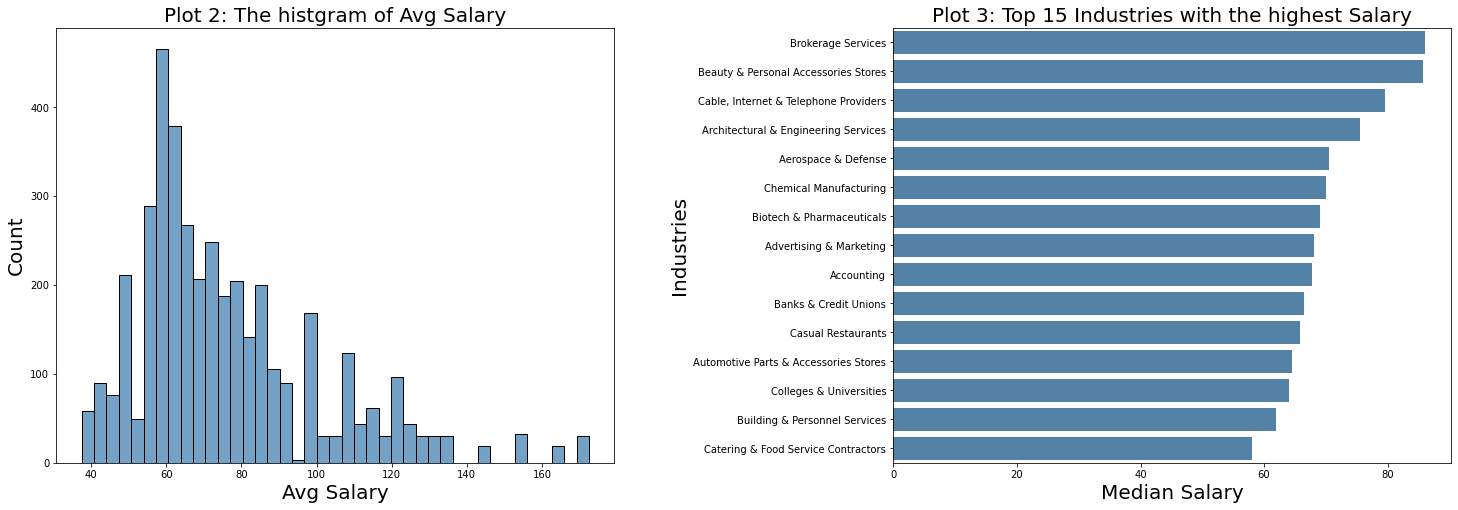

In [21]:
temp = data.groupby('Industry', as_index=False).agg(Industry_Avg_Salary=('Avg Salary','median'))

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(25,8))

_ = sns.histplot(data['Avg Salary'], color="steelblue", ax=ax1)
_ = sns.barplot(x='Industry_Avg_Salary', 
                y='Industry', 
                data=temp.head(15), 
                order=temp.head(15).sort_values('Industry_Avg_Salary', ascending=False).Industry, 
                color="steelblue",
                ax=ax2)

_ = ax1.set_title('Plot 2: The histgram of Avg Salary', fontsize=20)
_ = ax1.set_ylabel('Count', fontsize=20)
_ = ax1.set_xlabel('Avg Salary', fontsize=20)

_ = ax2.set_title('Plot 3: Top 15 Industries with the highest Salary', fontsize=20)
_ = ax2.set_ylabel('Industries', fontsize=20)
_ = ax2.set_xlabel('Median Salary', fontsize=20)
_ = plt.subplots_adjust(wspace=0.5)
_ = plt.show()

# Key Word Extraction 

### 1. Convert text into lowercase 

In [22]:
def lowerCase(s):
    return s['Job Description'].lower() 

data['Job Description'] = data.apply(lowerCase, axis=1)

### 2. Set Stop Words and Special Characters

In [23]:
from stop_words import get_stop_words
stop_words1 = stopwords.words('english')
stop_words2 = get_stop_words('english')
stop_words3 = [i.strip() for i in list(pd.read_csv("./stop-word-list.csv")['a'])]
stop_words4 = ['etc','and/or','\'ll','\'s','e.g','good']
stop_words = list(set(stop_words1 + stop_words2 + stop_words3 + stop_words4))

special_char = r'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~‘’•--●'

### 3. Word Tokenization with Lemmatization

Note that, since Lemmatization is highly impacted by the property of words, thus it gives more accurate Lemmatization to use nltk.pos_tag() function to get the tag (Noun, Adv, Adj, etc.) in advance.


In [24]:
# stemmer = PorterStemmer() # stemming
lemmatizer = WordNetLemmatizer() # lemmatizer

def get_teg(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

    
text_list_tfidf = []
for i in range(len(data)):
#     text = [lemmatizer.lemmatize(w) for w in word_tokenize(data['Job Description'][i]) if not w in stop_words and not w in special_char]
    text = [lemmatizer.lemmatize(w[0], get_teg(w[1]) or wordnet.NOUN) for w in pos_tag(word_tokenize(data['Job Description'][i])) if not w[0] in stop_words and not w[0] in special_char]
    text_list_tfidf.append(text)
    


# TF_IWF Model
According to Xiaolin Wang, etl.'s work on the improvement of TF-IDF, they have proposed a new model called TF-IWF (Term Frequency - Inverse Word Frequency), which was derived from TF-IDF (see the work in https://pdf.hanspub.org/CSA20130100000_81882762.pdf). The mathmatical model for TF-IWF is,
$$TF-IWF_{i,j} \to TF_{i,j} \times IWF_i = \frac{n_{i,j}}{ \sum_{k}n_{k,j} } \times log\frac{\sum_{i=1}^{m}nt_{i}}{ nt_i },$$

in which, $\sum_{i=1}^{m}nt_{i}$ means the total number of occurrences of all words in the corpus, and $nt_i $ indicates the totoal occurrence of word $ t_i$ in the corpus.

The difference between TF-IDF and TF-IWF is the way they calculated the relationship between a single word and the corpus. In TF-IDF, the IDF part represents the ratio of the total number of articles in the corpus to the number of articles containing a certain word. While in TF-IWF model, the IWF indicates the ratio of the total number of words in the corpus to the number of a certain word.  

As Wang, etl. stated, the new model has advantage on lowering the impact from texts with same types as well as handling the problem of small weights which may occur when using the model of TF-IDF. Thus, in this work, TF-IWF model has been realised to extract all keywords for the job descriptions listed on glassdoor.  

In [25]:
# tf-iwf model
# note that the dataframe has been used 
# in order to accelerate the calculation
# as 'for loop' in python is painfully slow
# especially when there are nested loops

data['tfiwf_kw'] = None
data['w2v_kw'] = None
data['lda_kw'] = None


def takeLog(s):
    return math.log(s['wf'])

iwf_df = pd.DataFrame(data=list(w for w1 in text_list_tfidf for w in w1), columns=['words']).groupby('words', as_index=False).agg(count=('words','count'))
iwf_df['wf'] = sum(iwf_df['count'])/iwf_df['count']
iwf_df['iwf'] = iwf_df.apply(takeLog, axis=1)


num_keywords = 5
count = 0
for i in range(len(text_list_tfidf)): 
    
    tf_df = pd.DataFrame(data=list(w for w in text_list_tfidf[i]), columns=['words']).groupby('words', as_index=False).\
               agg(word_count=('words','count')).\
               assign(tf= lambda x: x.word_count/len(text_list_tfidf[i]))
    tfiwf_df = tf_df.merge(iwf_df, how='left', on='words')
    tfiwf_df['tfiwf'] = tfiwf_df['tf']*tfiwf_df['iwf']
    tfiwf_df.sort_values('tfiwf', ascending=False, inplace=True)
    
    data.iloc[i, data.columns.get_loc('tfiwf_kw')] = ", ".join(list(tfiwf_df.head(num_keywords)['words']))
    
    
    if count < 20: # print the extracted keywords of 20 rows for demonstration 
        
        print("\nTop {} keywords in job {} <{}>:".format(num_keywords, i, data['Job Title'][i]))
        print("{}".format(list(tfiwf_df.head(num_keywords)['words'])))
        count += 1
    


Top 5 keywords in job 0 <Business Analyst - Clinical & Logistics Platform>:
['msk', 'platform', 'team', 'care', 'clinical']

Top 5 keywords in job 1 <Business Analyst>:
['data', 'investor', 'portfolio', 'specific', 'financial']

Top 5 keywords in job 2 <Data Analyst>:
['data', 'asembia', 'specialty', 'pharmacy', 'service']

Top 5 keywords in job 3 <Information Security Analyst, Incident Response>:
['security', 'bd', 'operation', 'alert', 'response']

Top 5 keywords in job 4 <Analyst - FP&A Global Revenue>:
['financial', 'analysis', 'revenue', 'rubicon', 'experience']

Top 5 keywords in job 5 <Data Analyst>:
['data', 'experience', 'healthcare', 'analyst/qa', 'quality']

Top 5 keywords in job 6 <Investment Analyst - Graduate>:
['investment', 'swiss', 'market', 'programme', 'financial']

Top 5 keywords in job 7 <IT Business Process Analysis>:
['business', 'commercialization', 'process', 'stakeholder', 'capability']

Top 5 keywords in job 8 <Tolling Business Analyst>:
['gannett', 'fleming

# Word2Vec and K-Means Clustering

In [26]:
from gensim.models import word2vec
from sklearn.cluster import KMeans
import kneed
import numpy as np
from scipy.spatial.distance import cdist

keywords_limit = 15

kmeans_kwargs = {
    "init": "k-means++",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 45,
}

count = 0
for i in range(len(data)):
    sentences = re.split(r'\.\n|\n\n\n|\n\n|\n|\. | \|', data['Job Description'][i].lower())

    sentence_list = []
    for sentence in sentences:
        sentence_list.append([lemmatizer.lemmatize(w[0], get_teg(w[1]) or wordnet.NOUN) for w in pos_tag(word_tokenize(sentence)) if not w[0] in stop_words and not w[0] in special_char])
    
    w2v = word2vec.Word2Vec(sentence_list, min_count=1, negative=10, sg=0)
    normalized_vectors = w2v.wv.get_normed_vectors()
    
    if len(normalized_vectors) >= 50: # if the job description is too short to find any keyword, it will print None
        
    
        sse = []
        for k in range(1, keywords_limit+1):
            kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
            _ = kmeans.fit(normalized_vectors)
            _ = sse.append(kmeans.inertia_)

            # _ = plt.style.use("fivethirtyeight")
            # _ = plt.plot(range(1, keywords_limit+1), sse)
            # _ = plt.xticks(range(1, keywords_limit+1))
            # _ = plt.xlabel("Number of Clusters")
            # _ = plt.ylabel("SSE")
            # plt.show()

        kl = kneed.KneeLocator(range(1,keywords_limit+1), sse, curve="convex", direction="decreasing")

        kmeans = KMeans(
        init="k-means++",
        n_clusters=(kl.elbow if kl.elbow != None else keywords_limit),
        n_init=10,
        max_iter=300,
        random_state=42
        )

        kResult = kmeans.fit_predict(normalized_vectors)

        min_dist = np.min(cdist(normalized_vectors, kmeans.cluster_centers_, 'euclidean'), axis=1)
        Y = pd.DataFrame(min_dist, index=[i for i in range(0,len(normalized_vectors))], columns=['keyword_id'])
        Z = pd.DataFrame(kResult, index=[i for i in range(0,len(normalized_vectors))], columns=['cluster_id'])
        PAP = pd.concat([Y,Z], axis=1)
        grouped = PAP.groupby(['cluster_id'])

        data.iloc[i, data.columns.get_loc('w2v_kw')] = ", ".join([w2v.wv.index_to_key[i] for i in list(grouped.idxmin()['keyword_id'])])

        if count < 20:
            print('\nkeywords in job {} <{}> keywords：'.format(i, data['Job Title'][i]))
            print([w2v.wv.index_to_key[i] for i in list(grouped.idxmin()['keyword_id'])])
            count += 1
    else:
        data.iloc[i, data.columns.get_loc('w2v_kw')] = None
        if count < 20:
            print('\nkeywords in job {} <{}> keywords：'.format(i, data['Job Title'][i]))
            print([])
            count += 1


keywords in job 0 <Business Analyst - Clinical & Logistics Platform> keywords：
['credibility', 'throughout', 'people', 'assistance', 'core', 'medical']

keywords in job 1 <Business Analyst> keywords：
['pressure', 'role', 'ecosystem', 'ensure', 'loader', 'fast-paced', 'reporting', 'exciting', 'investor', 'responsibility', 'include', 'people']

keywords in job 2 <Data Analyst> keywords：
['specialty', 'organizational', 'commit', 'industry', 'portability', 'file', 'responsibility']

keywords in job 3 <Information Security Analyst, Incident Response> keywords：
['analyst', 'ensure', 'bd', 'analysis', 'duty', 'support', 'description', 'collaboration', 'respond', 'alert', 'addition', 'improve', 'conduct', 'action', 'collaborate']

keywords in job 4 <Analyst - FP&A Global Revenue> keywords：
['bi', 'within', 'lunch', 'degree', 'match', 'global', 'demonstrated']

keywords in job 5 <Data Analyst> keywords：
['bi', 'assist', 'system', 'detail', 'new', 'multiple', 'actionable', 'wide', 'education', 

# LDA

Note that, the original code in this part was from 蕾姆233's blog on CSDN website. The article can be seen from https://blog.csdn.net/qq_34333481/article/details/84654348.


In [28]:
import jieba.posseg as jp
from gensim import corpora, models

dictionary = corpora.Dictionary(text_list_tfidf)
corpus = [dictionary.doc2bow(t) for t in text_list_tfidf]

lda = models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=6,iterations=200)

In [29]:

num_topics = 6  
num_show_term = 20  # 
topic_word_dict = {}   #
for topic_id in range(num_topics):
    templist = []
    term_distribute_all = lda.get_topic_terms(topicid=topic_id)
    a1 = lda.print_topics()
    term_distribute = term_distribute_all[:num_show_term]
    term_distribute = np.array(term_distribute)
    term_id = term_distribute[:, 0].astype(np.int)
    for t in term_id:
        templist.append(dictionary.id2token[t])
    topic_word_dict[topic_id] = templist


In [30]:
doc_topic_dict = {}  
doc_word_dict = {} 
for i in range(len(text_list_tfidf)):
    templist2 = [] 
    test_doc=text_list_tfidf[i]
    doc_bow = dictionary.doc2bow(test_doc)   
    num_show_topic = 2
    doc_topics = lda.get_document_topics(doc_bow) 
    #print(doc_topics)
    doc_topic_dict[i] = doc_topics[:num_show_topic]
    for topic in doc_topics:
        temp_word = topic_word_dict[topic[0]]
        templist2 += temp_word
    doc_word_dict[i] = templist2


In [31]:
count = 0
for i in range(len(text_list_tfidf)):
    keyword = []
    
    for word in text_list_tfidf[i]:
        if word in doc_word_dict[i]:
            keyword.append(word)
    
    data.iloc[i, data.columns.get_loc('lda_kw')] = ", ".join(set(keyword))
    
    if count < 20:
        print('\nkeywords in job {} <{}> keywords：'.format(i, data['Job Title'][i]))
        print(set(keyword))
        count += 1




keywords in job 0 <Business Analyst - Clinical & Logistics Platform> keywords：
{'support', 'management', 'team', 'business', 'year', 'system', 'data', 'information', 'provide', 'work', 'require', 'skill', 'application', 'ability', 'experience'}

keywords in job 1 <Business Analyst> keywords：
{'support', 'management', 'data', 'business', 'system', 'requirement', 'work', 'project', 'skill', 'ability', 'experience'}

keywords in job 2 <Data Analyst> keywords：
{'support', 'data', 'management', 'team', 'require', 'system', 'year', 'information', 'work', 'skill', 'hub', 'ability', 'experience'}

keywords in job 3 <Information Security Analyst, Incident Response> keywords：
{'team', 'business', 'information', 'security', 'project', 'work'}

keywords in job 4 <Analyst - FP&A Global Revenue> keywords：
{'support', 'data', 'management', 'business', 'year', 'system', 'team', 'provide', 'requirement', 'work', 'project', 'skill', 'ability', 'experience'}

keywords in job 5 <Data Analyst> keywords：
{

# Wordcloud
The comparison of the three ways of keyword extraction:
    1. Running time: the TF-IWF method and LDA method took way less time than the Word2Vec-Kmeans method. In the process of clustering, it needed to use the SSE method to find a suitable k and apply the culstering model for every document(or text). 
    2. The performance: since there are no labeled data, we are not able to discuss the the precision about the model.

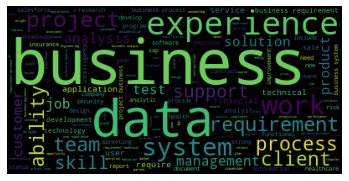

In [41]:
import wordcloud

# data['tfiwf_kw'][1].split(",")
def splittoList(s):
    return s.split(', ')

tfiwf_kw_list = []
for i in data['tfiwf_kw'].apply(splittoList):
    tfiwf_kw_list += i
    
tfiwf_kw_count = pd.DataFrame(data=tfiwf_kw_list, columns=['keyword'])
# tfiwf_kw_count.groupby('keyword').agg(count=('keyword','count')).sort_values('count', ascending=False).head(10)

w = wordcloud.WordCloud()
w.generate(text = ' '.join(tfiwf_kw_list))
_=plt.imshow(w)
_=plt.axis('off')
_=plt.show()

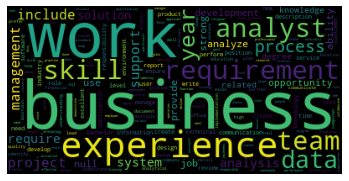

In [42]:
data['w2v_kw'].replace({None:'null'}, inplace=True)

w2v_kw_list = []
for i in data['w2v_kw'].apply(splittoList):
    w2v_kw_list += i
    
w2v_kw_count = pd.DataFrame(data=w2v_kw_list, columns=['keyword'])
# w2v_kw_count.groupby('keyword').agg(count=('keyword','count')).sort_values('count', ascending=False).head(10)
w = wordcloud.WordCloud()
w.generate(text = ' '.join(w2v_kw_list))
_=plt.imshow(w)
_=plt.axis('off')
_=plt.show()

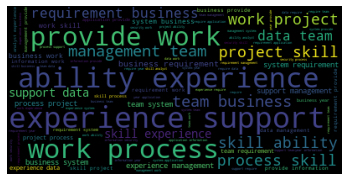

In [44]:
lda_kw_list = []
for i in data['lda_kw'].apply(splittoList):
    lda_kw_list += i
    
lda_kw_count = pd.DataFrame(data=lda_kw_list, columns=['keyword'])
# lda_kw_count.groupby('keyword').agg(count=('keyword','count')).sort_values('count', ascending=False).head(10)
w = wordcloud.WordCloud()
w.generate(text = ' '.join(lda_kw_list))
_=plt.imshow(w)
_=plt.axis('off')
_=plt.show()

# Future Work
1. The similarity between texts
2. Knowledge Graph
3. Other Practices: Sentiment Analysis, Text Classification


# Backup Codes